입력 이미지로 사용될 이미지 다운로드/보기

In [1]:
!mkdir ./data

!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

--2022-06-21 02:12:06--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.05s   

2022-06-21 02:12:06 (7.53 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



Darknet Yolo사이트에서 coco로 학습된 Inference모델와 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성

In [2]:
!mkdir ./pretrained

# yolo를 이용하여 이미지Object Detection
!wget -O ./pretrained/yolov3.weights https://pjreddie.com/media/files/yolov3.weights
!wget -O ./pretrained/yolov3.cfg https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

# tiny-yolo 를 이용하여 Object Detection
!wget -O ./pretrained/yolov3-tiny.weights https://pjreddie.com/media/files/yolov3-tiny.weights
!wget -O ./pretrained/yolov3-tiny.cfg https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3-tiny.cfg

--2022-06-21 02:12:09--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘./pretrained/yolov3.weights’

./pretrained/yolov3 100%[===================>] 236.52M  59.5MB/s    in 4.1s    

2022-06-21 02:12:14 (57.6 MB/s) - ‘./pretrained/yolov3.weights’ saved [248007048/248007048]

--2022-06-21 02:12:14--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘./pretrained/yolov3.cfg’

./pretrained/yolov3 100%[================

readNetFromDarknet(config파일, weight파일)을 이용하여 yolo inference network 모델을 로딩

In [3]:
import cv2

config_file="/content/pretrained/yolov3.cfg"
pretrained_model_file="/content/pretrained/yolov3.weights"

# config 파일 인자가 먼저 온다
cv_net_yolo=cv2.dnn.readNetFromDarknet(config_file,pretrained_model_file)

3개의 scale Output layer에서 결과 데이터 추출

In [5]:
# 3개의 feature map에서 결과를 추출하는 코드 (13 x 13, 26 x 26, 52 x 52)

layer_names=cv_net_yolo.getLayerNames()
print('### yolo v3 layer name:',layer_names)
# cv_net_yolo.getUnconnectedOutLayers()이거의 출력 결과는 conv layer 뿐만아니라 모든 layer를 포함해서 찾은 index이다
outputlayer_index=cv_net_yolo.getUnconnectedOutLayers()
print('final output layer id:',outputlayer_index)
# 밑의 코드의 결과는 conv layer를 기준으로 봤을 때의 layer번호를 의미한다(yolo_106)
outputlayer_names=[layer_names[i[0]-1] for i in outputlayer_index]
print('final output layer name:',outputlayer_names)

### yolo v3 layer name: ['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37',

3개의 scale output layer에서 Object Detection 정보를 모두 수집.

In [6]:
# DarkNet은 0에서부터 79
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

In [9]:
import numpy as np

img=cv2.imread("/content/data/beatles01.jpg")
img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# 로딩한 모델은 Yolov3 416 x 416 모델이다
blob=cv2.dnn.blobFromImage(img,scalefactor=1/255.0,size=(416,416),swapRB=True,crop=False)
cv_net_yolo.setInput(blob)

cv_outs=cv_net_yolo.forward(outputlayer_names)
print("cv_outs의 내부 원소 갯수 :",len(cv_outs))
print(cv_outs[0].shape,cv_outs[1].shape,cv_outs[2].shape,"\n")

# (507, 85)   ->  13 x 13 feature map에서 뽑아 온거
# (2028, 85)  ->  26 x 26 feature map에서 뽑아 온거
# (8112, 85)  ->  52 x 52 feature map에서 뽑아 온거
# 
# (507, 85) (2028, 85) (8112, 85)에서 85가 뜻하는 것은
# 개별 anchor box별로 85개의 데이터를 가지고 있다는 것이다 

# (507, 85) (2028, 85) (8112, 85)에서 507, 2028, 8112가 뜻하는 것은
# 507 = 13 x 13 x 3
# 2028 = 26 x 26 x 3
# 8112 = 52 x 52 x 3

# 원본 이미지를 네트웍에 입력시에는 (416, 416)로 resize 한다 
# 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요하다
rows,cols=img.shape[:2]

class_ids=[]
confidences=[]
bboxes=[]
# 3개의 개별 output layer별로 Detect된 Object들에 대해서 Detection 정보 추출 및 시각화
for index_1,output in enumerate(cv_outs):
  print("output shape : ",output.shape)
  # feature map에 있는 anchor 갯수만큼 iteration하면서 Detected 된 Object 추출.(13x13x3, 26x26x3, 52x52x3)
  for index_2,detection in enumerate(output):
    # class score는 detetection배열에서 5번째 이후 위치에 있는 값.
    class_scores=detection[5:]
    # class_scores배열에서 가장 높은 값을 가지는 값이 class confidence, 그리고 그때의 위치 인덱스가 class id
    class_id=np.argmax(class_scores)
    confidence=class_scores[class_id]

    if confidence>0.5:
      print("index_1",index_1,"index_2",index_2,"class_id",class_id,"confidence",confidence)
      
      center_x=int(detection[0]*cols)
      center_y=int(detection[1]*rows)
      width=int(detection[2]*cols)
      height=int(detection[3]*rows)
      left=int(center_x-(width/2))
      top=int(center_y-(height/2))

      class_ids.append(class_id)
      confidences.append(float(confidence))
      bboxes.append([left,top,width,height])
  
  print()


cv_outs의 내부 원소 갯수 : 3
(507, 85) (2028, 85) (8112, 85) 

output shape :  (507, 85)
index_1 0 index_2 319 class_id 0 confidence 0.9317017
index_1 0 index_2 328 class_id 0 confidence 0.96232384
index_1 0 index_2 334 class_id 0 confidence 0.9984486
index_1 0 index_2 343 class_id 0 confidence 0.9978433

output shape :  (2028, 85)
index_1 1 index_2 831 class_id 2 confidence 0.8169964
index_1 1 index_2 955 class_id 2 confidence 0.8472691
index_1 1 index_2 1262 class_id 0 confidence 0.9877816
index_1 1 index_2 1280 class_id 0 confidence 0.99840033
index_1 1 index_2 1295 class_id 0 confidence 0.6916561
index_1 1 index_2 1313 class_id 0 confidence 0.9205806

output shape :  (8112, 85)
index_1 2 index_2 2883 class_id 2 confidence 0.9077368
index_1 2 index_2 2886 class_id 2 confidence 0.63324535
index_1 2 index_2 3048 class_id 2 confidence 0.9412014
index_1 2 index_2 3051 class_id 2 confidence 0.615405
index_1 2 index_2 3184 class_id 2 confidence 0.95041
index_1 2 index_2 3214 class_id 2 confidenc

NMS를 이용하여 각 Output layer에서 Detected된 Object의 겹치는 Bounding box를 제외.

In [10]:
bboxes,confidences

([[45, 250, 175, 314],
  [247, 243, 156, 307],
  [383, 266, 195, 292],
  [570, 259, 176, 302],
  [505, 228, 68, 66],
  [137, 247, 119, 93],
  [65, 271, 129, 268],
  [261, 253, 114, 290],
  [410, 281, 133, 254],
  [593, 269, 140, 280],
  [383, 219, 17, 17],
  [404, 216, 15, 11],
  [433, 223, 22, 18],
  [449, 226, 19, 18],
  [312, 235, 39, 32],
  [471, 233, 33, 29],
  [489, 238, 28, 42],
  [606, 229, 21, 63]],
 [0.9317017197608948,
  0.9623238444328308,
  0.9984486103057861,
  0.997843325138092,
  0.8169963955879211,
  0.8472691178321838,
  0.9877815842628479,
  0.9984003305435181,
  0.6916561126708984,
  0.9205806255340576,
  0.9077367782592773,
  0.6332453489303589,
  0.941201388835907,
  0.6154050230979919,
  0.950410008430481,
  0.9064124822616577,
  0.6899800300598145,
  0.764070451259613])

In [11]:
conf_threshold=0.5
nms__threshold=0.4

idxs=cv2.dnn.NMSBoxes(bboxes,confidences,conf_threshold,nms__threshold)
idxs

array([[ 2],
       [ 7],
       [ 3],
       [ 6],
       [14],
       [12],
       [10],
       [15],
       [ 5],
       [ 4],
       [17],
       [16],
       [11],
       [13]], dtype=int32)

NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.

person : 0.9984
person : 0.9984
person : 0.9978
person : 0.9878
car : 0.9504
car : 0.9412
car : 0.9077
car : 0.9064
car : 0.8473
car : 0.8170
person : 0.7641
car : 0.6900
car : 0.6332
car : 0.6154


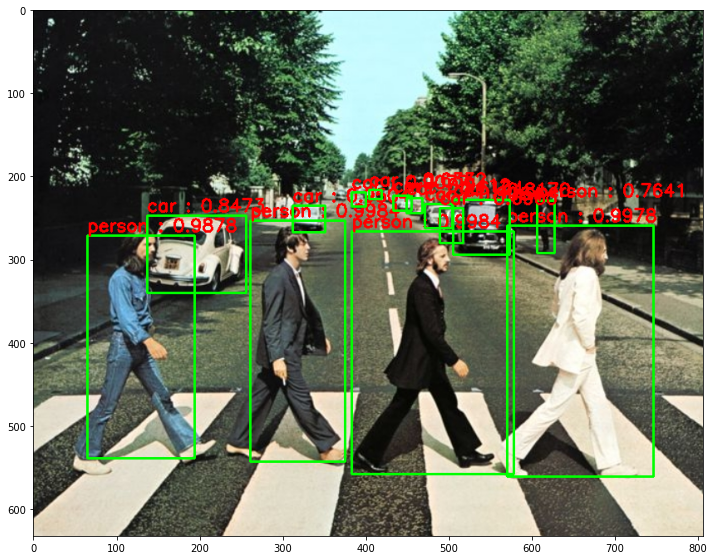

In [12]:
import matplotlib.pyplot as plt

draw_img=img.copy()
# NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
if len(idxs)>0:
  for i in idxs.flatten():
    box=bboxes[i]
    left=int(box[0])
    top=int(box[1])
    width=int(box[2])
    height=int(box[3])

    caption="{} : {:.4f}".format(labels_to_names_seq[class_ids[i]],confidences[i])

    cv2.rectangle(draw_img,(left,top),(left+width,top+height),color=(0,255,0),thickness=2)
    cv2.putText(draw_img,caption,(left,top-5),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,0,255),2)

    print(caption)

img_rgb=cv2.cvtColor(draw_img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,112))
plt.imshow(img_rgb)



In [ ]:
# 함수화

In [14]:
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

In [17]:
def get_detected_img(img_array,cv_net_yolo,conf_threshold=0.5,nms_threshold=0.4):

  draw_img=img_array.copy()

  layer_names=cv_net_yolo.getLayerNames()
  outputlayer_index=cv_net_yolo.getUnconnectedOutLayers()
  outputlayer_names=[layer_names[i[0]-1] for i in outputlayer_index]

  blob=cv2.dnn.blobFromImage(img_array,scalefactor=1/255.0,size=(416,416),swapRB=True,crop=False)
  cv_net_yolo.setInput(blob)
  cv_outs=cv_net_yolo.forward(outputlayer_names)

  rows,cols=img_array.shape[:2]

  class_ids=[]
  confidences=[]
  bboxes=[]

  for index_1, output in enumerate(cv_outs):
    print("output shape",output.shape)
    for index_2, det in enumerate(output):
      
      class_score=det[5:]
      class_id=np.argmax(class_score)
      confidence=class_score[class_id]

      if confidence>conf_threshold:
        #print("index_1",index_1,"index_2",index_2,"class_id",class_id,"confidence",confidence)
        center_x=int(det[0]*cols)
        center_y=int(det[1]*rows)
        width=int(det[2]*cols)
        height=int(det[3]*rows)
        left=int(center_x-(width/2))
        top=int(center_y-(height/2))

        class_ids.append(class_id)
        confidences.append(float(confidence))
        bboxes.append([left,top,width,height])

  #print(bboxes)
  idxs = cv2.dnn.NMSBoxes(bboxes, confidences, conf_threshold, nms_threshold)

  if len(idxs)>0:
    for i in idxs.flatten():
      bbox=bboxes[i]
      left=int(bbox[0])
      top=int(bbox[1])
      right=int(bbox[2]+left)
      bottom=int(bbox[3]+top)

      caption="{} : {:.4f}".format(labels_to_names_seq[class_ids[i]],confidences[i])

      cv2.rectangle(draw_img,(left,top),(right,bottom),color=(0,255,0),thickness=2)
      cv2.putText(draw_img,caption,(left,top-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1)

  return draw_img


In [18]:
config_file="/content/pretrained/yolov3.cfg"
pretrained_model_file="/content/pretrained/yolov3.weights"

cv_net_yolo=cv2.dnn.readNetFromDarknet(config_file,pretrained_model_file)

output shape (507, 85)
output shape (2028, 85)
output shape (8112, 85)


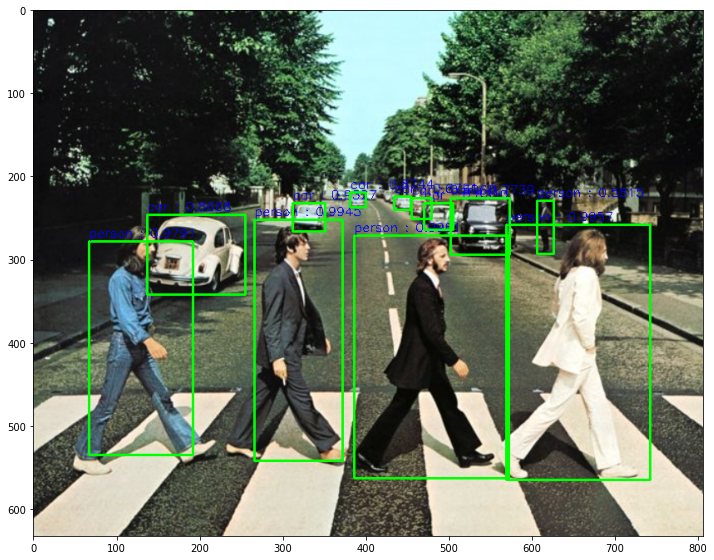

In [19]:
img=cv2.imread("/content/data/beatles01.jpg")
img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

draw_img=get_detected_img(img_rgb,cv_net_yolo,conf_threshold=0.5,nms_threshold=0.4)

plt.figure(figsize=(12,12))
plt.imshow(draw_img)

tiny Yolo로 Object Detection 수행하기.

output shape (507, 85)
output shape (2028, 85)


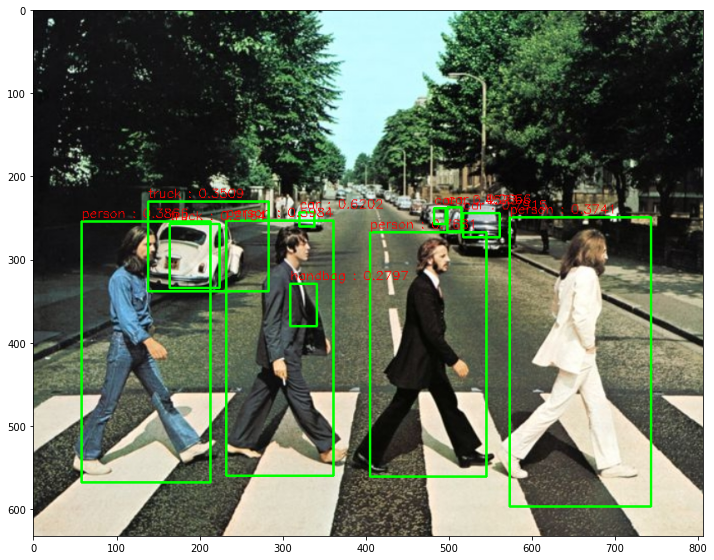

In [20]:
img = cv2.imread('/content/data/beatles01.jpg')

weights_path = '/content/pretrained/yolov3-tiny.weights'
config_path =  '/content/pretrained/yolov3-tiny.cfg'


cv_net_yolo_tiny = cv2.dnn.readNetFromDarknet(config_path, weights_path)

conf_threshold = 0.2
nms_threshold = 0.4

draw_img = get_detected_img(img,cv_net_yolo_tiny,conf_threshold=0.2,nms_threshold=0.4)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)